# 1. Import

In [1]:
%load_ext autoreload
%autoreload 2

import cfg
from src import data_loader, models, trainer, evaluate
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

trainer.set_seed(cfg.RANDOM_STATE)


# 2. Data loading

In [2]:
if cfg.IMBALANCED_MODE == True: 
    X_train, Y_train, X_val, Y_val, X_test, Y_test = data_loader.data_import(cfg.OVERLAPPING_RATIO,cfg.BASE_PATH,cfg.SAMPLE_LENGTH, cfg.PREPROCESSING)
    X_train_imbalanced, Y_train_imbalanced = data_loader.create_imbalanced_data(X_train, Y_train, cfg.IMBALANCED_RATIO, cfg.NUM_CLASSES)
    X_train_normalized, X_val_normalized, X_test_normalized = data_loader.normalize_data(X_train_imbalanced, X_val, X_test)
    X_train_smoted, Y_train_smoted = data_loader.apply_smote(X_train_normalized, Y_train_imbalanced, cfg.RANDOM_STATE, cfg.SAMPLE_LENGTH)
    train_loader, val_loader, test_loader = data_loader.create_dataloaders(X_train_smoted, Y_train_smoted,
                                                                            X_val_normalized, Y_val,
                                                                            X_test_normalized, Y_test,
                                                                            cfg.SAMPLE_LENGTH, cfg.CNN1D_INPUT, cfg.BATCH_SIZE, cfg.RANDOM_STATE)
else:
    X_train, Y_train, X_val, Y_val, X_test, Y_test = data_loader.data_import(cfg.OVERLAPPING_RATIO,cfg.BASE_PATH,cfg.SAMPLE_LENGTH,cfg.PREPROCESSING)
    X_train_normalized, X_val_normalized, X_test_normalized = data_loader.normalize_data(X_train, X_val, X_test)
    train_loader, val_loader, test_loader = data_loader.create_dataloaders(X_train, Y_train,
                                                                            X_val, Y_val,
                                                                            X_test, Y_test,
                                                                            cfg.SAMPLE_LENGTH, cfg.CNN1D_INPUT, cfg.BATCH_SIZE, cfg.RANDOM_STATE)

>>> Importing: Record = '97', Key = 'DE'
    [INFO] Label: Normal
    [INFO] Size: 119
>>> Importing: Record = '97', Key = 'FE'
    [INFO] Label: Normal
    [INFO] Size: 119
>>> Importing: Record = '98', Key = 'DE'
    [INFO] Label: Normal
    [INFO] Size: 236
>>> Importing: Record = '209', Key = 'FE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '210', Key = 'DE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '278', Key = 'DE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '278', Key = 'FE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '280', Key = 'DE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '280', Key = 'BA'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '271', Key = 'DE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '271', Key = 'FE'
    [INFO] Label: IR
    [INFO] Size: 59
>>> Importing: Record = '276', Key = 'BA'
    [INFO] Label: IR
    [INFO] S

# 3. Model defining

In [3]:
if cfg.MODEL_TYPE == 'student':
  print("Using StudentModel")
  model_test = models.StudentModel_Improved(cfg.NUM_CLASSES)
if cfg.MODEL_TYPE == 'teacher':
  print("Using TeacherModel")
  model_test = models.TeacherModel(cfg.NUM_CLASSES)

if cfg.MODEL_TYPE == '1D':
  print("Using 1DCNNModel")
  model_test = models.Basic1DCNN(1,cfg.NUM_CLASSES)

if cfg.MODEL_TYPE == '1D-Basic':
  print("Using 1DCNNModel")
  model_test = models.Basic1DCNN(1, cfg.NUM_CLASSES)
  
# summary(model_test, input_size=(cfg.BATCH_SIZE, 1,cfg.LENGTH))
size = int(cfg.SAMPLE_LENGTH**(1/2))
summary(model_test, input_size=(cfg.BATCH_SIZE, 1, size, size))


Using StudentModel


Layer (type:depth-idx)                   Output Shape              Param #
StudentModel_Improved                    [128, 3]                  --
├─Sequential: 1-1                        [128, 128, 32, 32]        --
│    └─Conv2d: 2-1                       [128, 8, 32, 32]          72
│    └─BatchNorm2d: 2-2                  [128, 8, 32, 32]          16
│    └─ReLU: 2-3                         [128, 8, 32, 32]          --
│    └─Conv2d: 2-4                       [128, 16, 32, 32]         1,152
│    └─BatchNorm2d: 2-5                  [128, 16, 32, 32]         32
│    └─ReLU: 2-6                         [128, 16, 32, 32]         --
│    └─Conv2d: 2-7                       [128, 32, 32, 32]         4,608
│    └─BatchNorm2d: 2-8                  [128, 32, 32, 32]         64
│    └─ReLU: 2-9                         [128, 32, 32, 32]         --
│    └─Conv2d: 2-10                      [128, 64, 32, 32]         18,432
│    └─BatchNorm2d: 2-11                 [128, 64, 32, 32]         128
│   

# 4. Training

In [4]:
print(f'Using device: {cfg.DEVICE}')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_test.parameters(), lr= cfg.LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= cfg.NUM_EPOCHS, eta_min=cfg.LEARNING_RATE *1e-2)
trained_model, history = trainer.train_model(model_test, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=cfg.NUM_EPOCHS, device=cfg.DEVICE)

Using device: cuda
Epoch 1/200 | Train Loss: 0.9358 Acc: 52.91% | Val Loss: 1.1063 Acc: 29.44%
Epoch 2/200 | Train Loss: 0.7700 Acc: 63.34% | Val Loss: 1.5061 Acc: 47.01%
Epoch 3/200 | Train Loss: 0.6871 Acc: 64.20% | Val Loss: 1.7191 Acc: 47.01%
Epoch 4/200 | Train Loss: 0.6432 Acc: 68.07% | Val Loss: 1.7007 Acc: 47.01%
Epoch 5/200 | Train Loss: 0.6138 Acc: 69.31% | Val Loss: 1.1628 Acc: 53.19%
Epoch 6/200 | Train Loss: 0.5818 Acc: 71.78% | Val Loss: 0.5896 Acc: 74.75%
Epoch 7/200 | Train Loss: 0.5589 Acc: 73.25% | Val Loss: 0.5498 Acc: 71.96%
Epoch 8/200 | Train Loss: 0.5297 Acc: 75.12% | Val Loss: 0.5228 Acc: 71.46%
Epoch 9/200 | Train Loss: 0.4938 Acc: 78.35% | Val Loss: 0.5764 Acc: 81.34%
Epoch 10/200 | Train Loss: 0.4782 Acc: 78.50% | Val Loss: 0.5247 Acc: 76.95%
Epoch 11/200 | Train Loss: 0.4415 Acc: 80.64% | Val Loss: 0.5217 Acc: 76.25%
Epoch 12/200 | Train Loss: 0.4296 Acc: 80.71% | Val Loss: 0.4785 Acc: 74.65%
Epoch 13/200 | Train Loss: 0.4058 Acc: 81.76% | Val Loss: 0.4594 A

# 5. Evaluating

Confusion Matrix


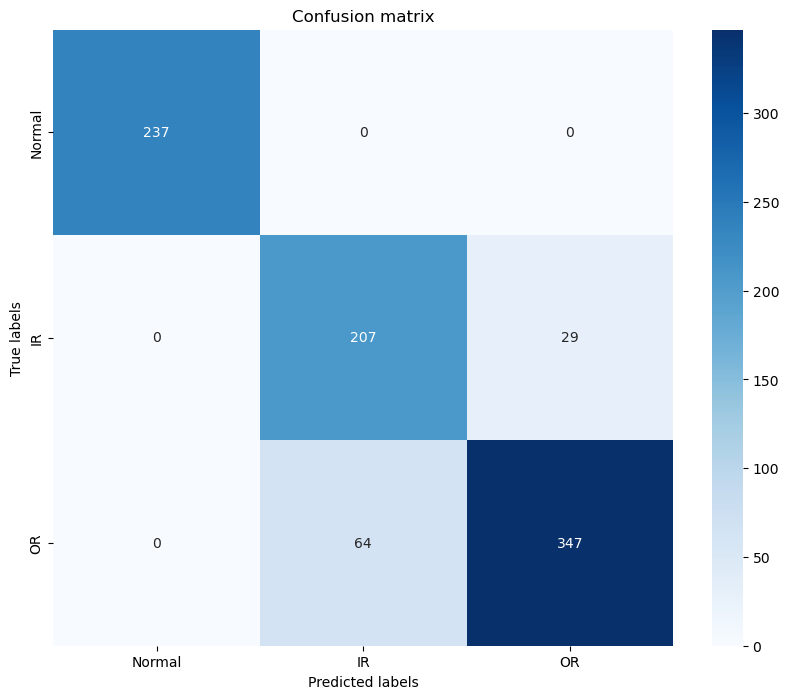

 - Model accuracy: 89.48%

t-SNE
Trích xuất được 884 features với 128 chiều.


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


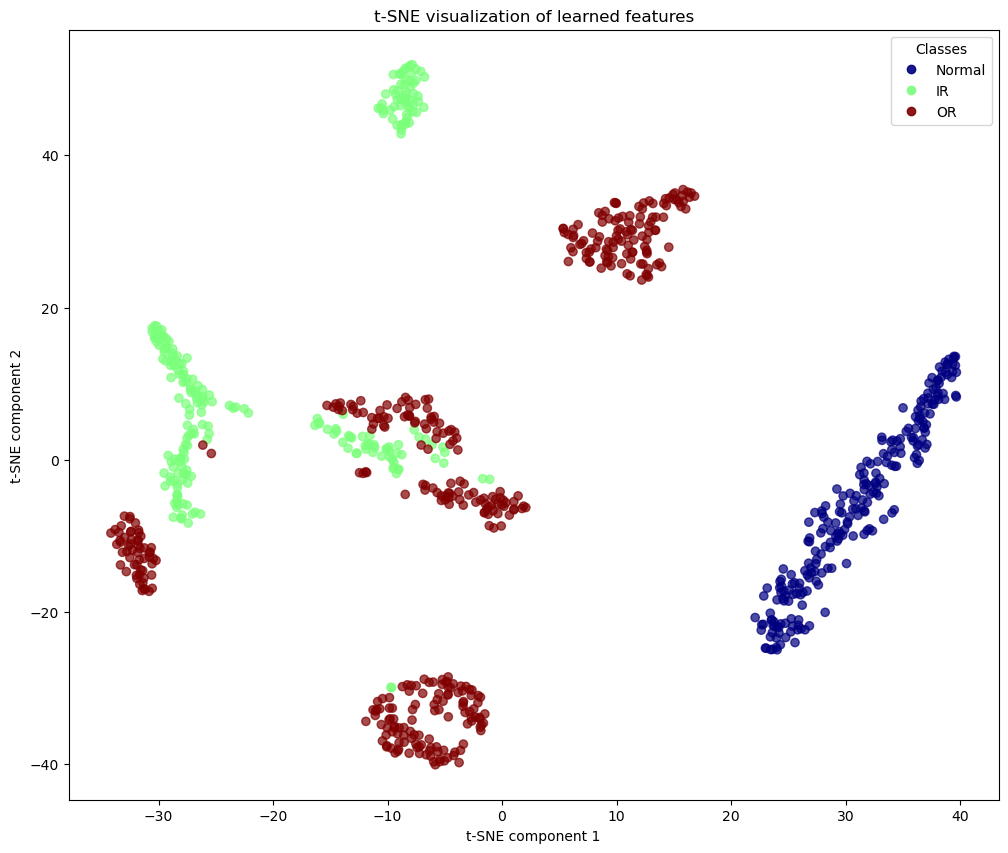


History


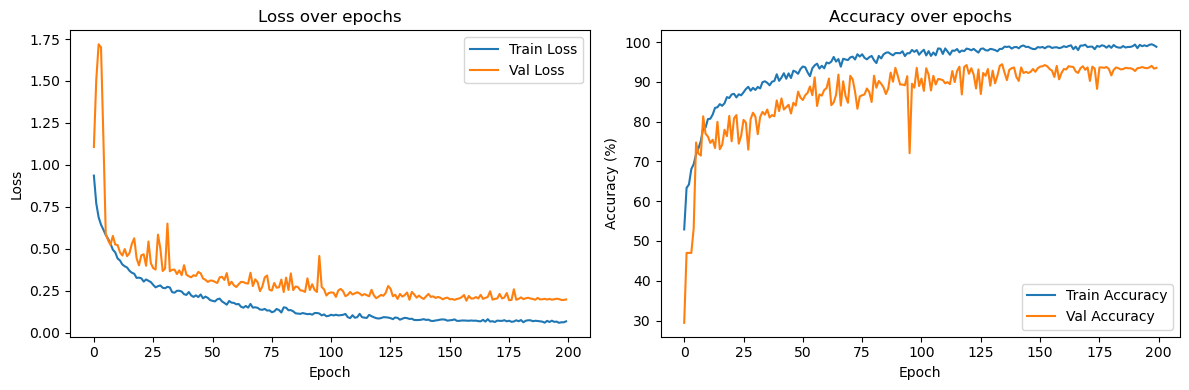

In [5]:
print("Confusion Matrix")
evaluate.plot_confusion_matrix(trained_model, test_loader, 'cpu', cfg.CLASS_NAMES)

print("\nt-SNE")
evaluate.plot_tsne(trained_model, test_loader, 'cpu', cfg.CLASS_NAMES, n_iter=1000, perplexity=30) # n_iter và perplexity có thể cần điều chỉnh

print("\nHistory")
evaluate.plot_history(history)

Confusion Matrix


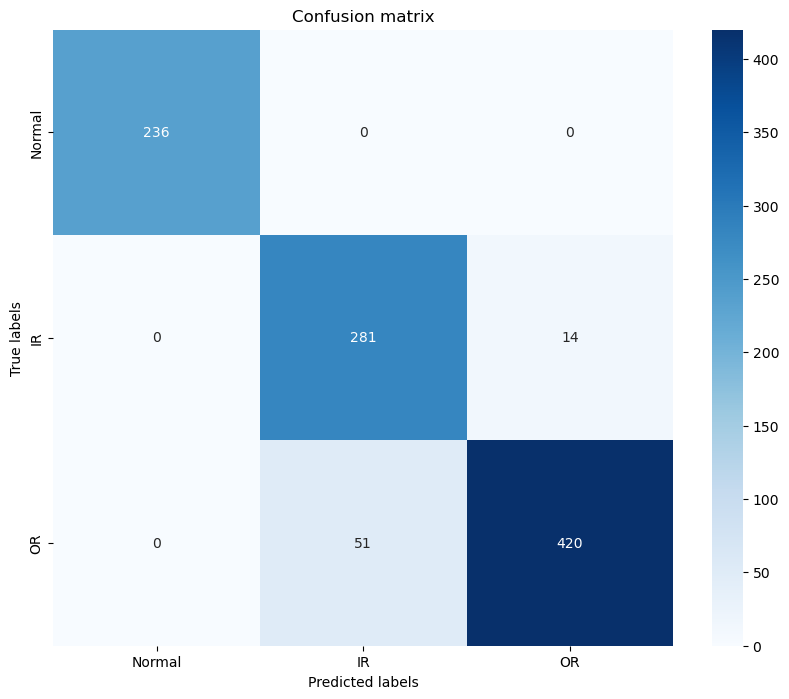

 - Model accuracy: 93.51%

t-SNE
Trích xuất được 1002 features với 128 chiều.


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


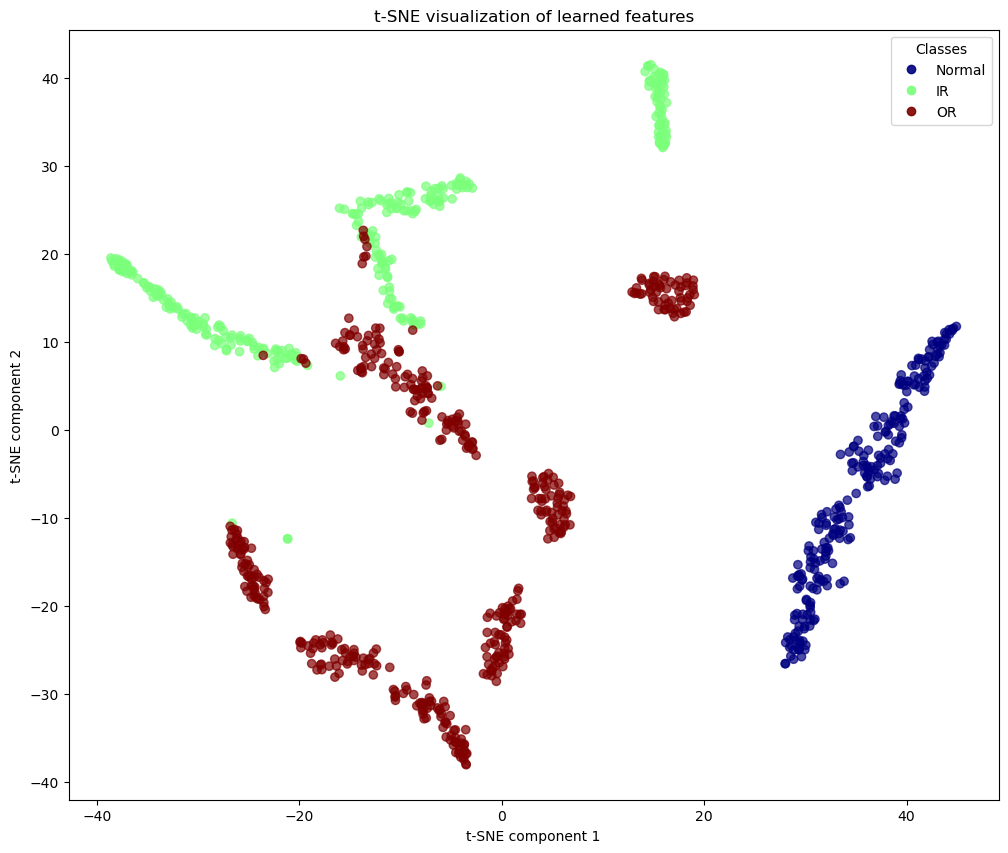

In [6]:
print("Confusion Matrix")
evaluate.plot_confusion_matrix(trained_model, val_loader, 'cpu', cfg.CLASS_NAMES)

print("\nt-SNE")
evaluate.plot_tsne(trained_model, val_loader, 'cpu', cfg.CLASS_NAMES, n_iter=1000, perplexity=30) # n_iter và perplexity có thể cần điều chỉnh

Confusion Matrix


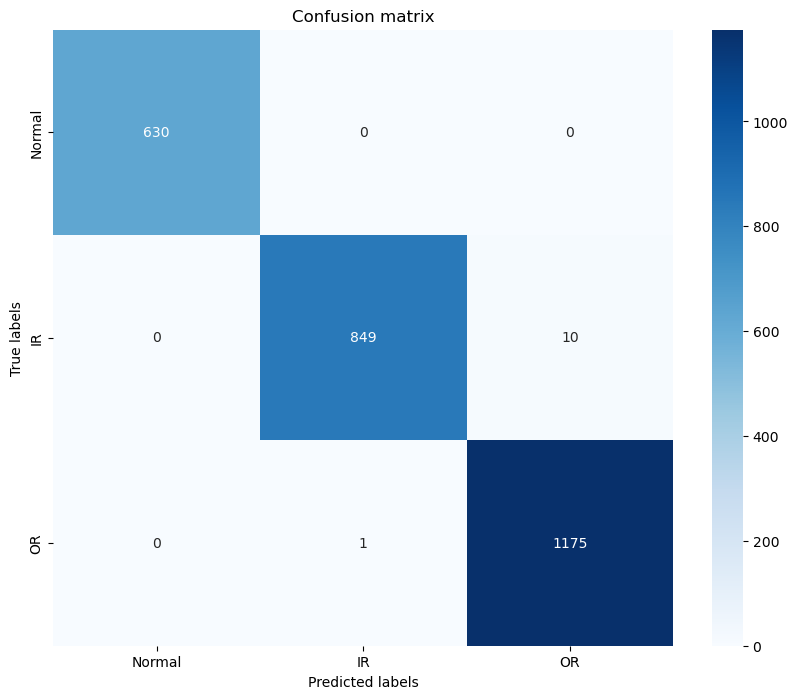

 - Model accuracy: 99.59%

t-SNE
Trích xuất được 2665 features với 128 chiều.


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


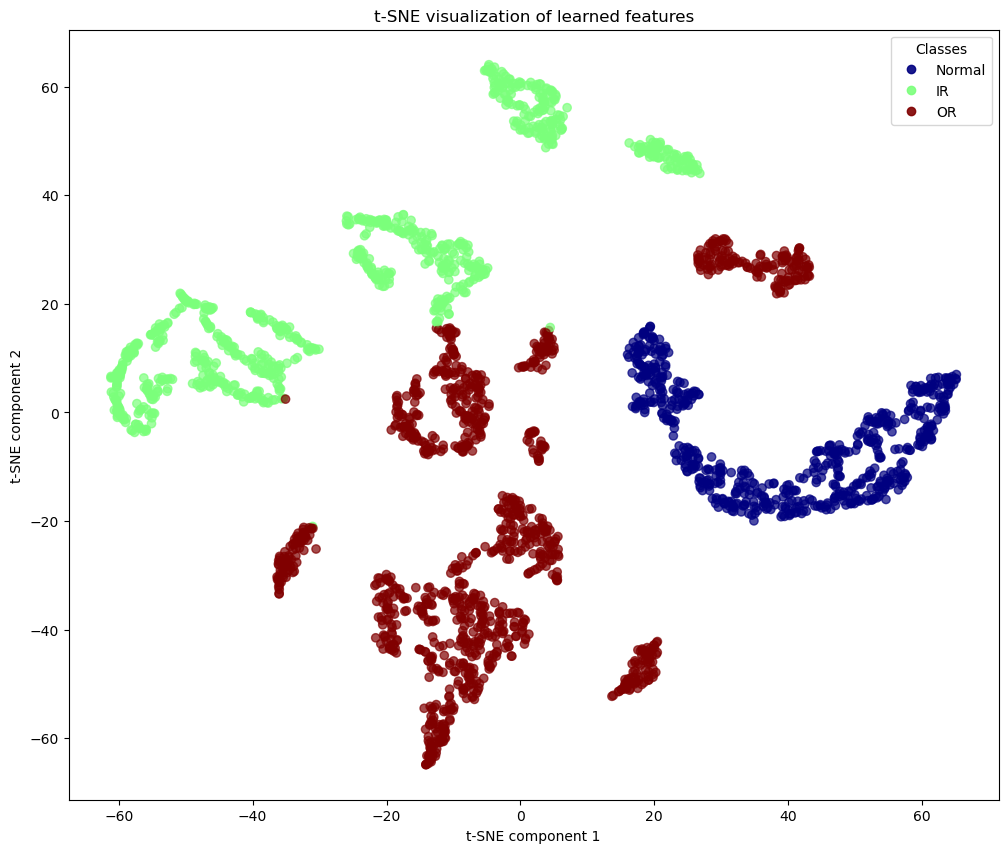

In [7]:
print("Confusion Matrix")
evaluate.plot_confusion_matrix(trained_model, train_loader, 'cpu', cfg.CLASS_NAMES)

print("\nt-SNE")
evaluate.plot_tsne(trained_model, train_loader, 'cpu', cfg.CLASS_NAMES, n_iter=1000, perplexity=30) # n_iter và perplexity có thể cần điều chỉnh

In [8]:
test_files = [
    # --- Normal Data (Label 0) ---
    '100DE', #'100FE', # Normal @ 3HP

    # --- Inner Race (IR) Faults (Label 2) ---
    #'212DE',          # DE, IR, 0.021"
    #'281DE',          # FE, IR, 0.007"
    '275FE',          # FE, IR, 0.014"
    '273DE', '273FE', '273BA', # FE, IR, 0.021"

    # --- Outer Race (OR) Faults (Label 3) ---
    '133DE',          # DE, OR (Centred), 0.021"
    '147DE', '147FE', '147BA', # DE, OR (Orthogonal), 0.021"
    '160DE',          # DE, OR (Opposite), 0.021"
    '317DE', '317FE', #'317BA', # FE, OR (Orthogonal), 0.021"
]

data_loader.evaluate_files(trained_model, test_files, cfg)

>>> Importing: Record = '100', Key = 'DE'
    [INFO] Label: Normal
    [INFO] Size: 474
Class 0: 132 samples (55.70%)
Class 2: 105 samples (44.30%)
>>> Importing: Record = '275', Key = 'FE'
    [INFO] Label: IR
    [INFO] Size: 118
Class 1: 59 samples (100.00%)
>>> Importing: Record = '273', Key = 'DE'
    [INFO] Label: IR
    [INFO] Size: 118
Class 1: 58 samples (98.31%)
Class 2: 1 samples (1.69%)
>>> Importing: Record = '273', Key = 'FE'
    [INFO] Label: IR
    [INFO] Size: 118
Class 1: 53 samples (89.83%)
Class 2: 6 samples (10.17%)
>>> Importing: Record = '273', Key = 'BA'
    [INFO] Label: IR
    [INFO] Size: 118
Class 1: 59 samples (100.00%)
>>> Importing: Record = '133', Key = 'DE'
    [INFO] Label: OR
    [INFO] Size: 119


ValueError: cannot reshape array of size 60928 into shape (1,32,32)